# Assignment participants and contributors
1. Garren Wee (U2221122F)
  - Researched on reinforcement learning mechanisms
  - Presented analysis of model in documentation
  - Augmented readability of notebook
2. Chin Jun Hao, Mark (U2221742F)
  - Research on the reinforcement learning agent
  - Trained the model and used it to generate outcomes
  - Presented findings in plotting visuals and generating video output
3. Yannaroj Chua (U2120556H)
  - Debugged video output to ensure presentability
  - Tested code and ensured functionality
  - Optimized model accuracy for correctness

# Importing of required dependencies and modules
We will first import a selection of dependencies such as Gym, Torch, and Matplot, as well as define a helper function that will serve in rendering a video later on.

**Note that for the model to work, the file "discount_model" must be inserted into the "content" folder, such that it can be accessed via "./discount_model" in the code later on.**

In [3]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
import numpy as np
from itertools import count
from collections import deque
from random import random

import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# imports from template

!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data=''''''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

In [5]:
env = gym.make('CartPole-v1')

#**TASK 1: Development of an RL agent**

#Implementing a Policy-based reinforcement learning model (REINFORCE)
We will be using a neural network, utilising PyTorch's nn module with just one layer in the PolicyNN class. The layer takes an input of size 4, which corresponds to the size of Cartpole's observation space (cart position, cart velocity, pole angle and pole velocity), and has an output of size 2 for the action space (left and right movements).

[The solution we have referenced for this approach](https://bytepawn.com/solving-the-cartpole-reinforcement-learning-problem-with-pytorch.html) does not have a discount factor, which would help for encouraging the agent to prioritise long-term rewards for infinite horizon MDPs and to assist in convergence. Thus, we decided to adopt these [adapted functions](https://github.com/pytorch/examples/blob/main/reinforcement_learning/reinforce.py), which provide a combination of loss and discount calculating functions. The respective discounted rewards are calculated in the algorithm as follows:


$$
G_t = R_t + \gamma R_{t+1} + \gamma^2 R_{t+2} + \ldots = \sum_{k=0}^{\infty} \gamma^k R_{t+k}
$$

where $ G_t $ represents the cumulative return at time step $ t $, $ R_t $ is the respective returns received, $ 0< \gamma < 1$ is the discount factor, and $k$ represents all future time steps.

The loss function aims to drive maximum reward yield through policy parameter adjustments, and is commonly used in policy gradient algorithms like REINFORCE. The equation is as follows:

$$
L_t = - \log \pi(a_t | s_t) \cdot N_t
$$

where $t$ is the time step, $ \pi(a_t | s_t) $ is the probability according to the policy network of taking action $ a_t $ given state $ s_t $, and $ N_t $ is the discounted rewards after normalization. The normalisation process is

   $$
   \text N_t = \frac{{\text{returns} - \text{mean(returns)}}}{{\text{std(returns)} + \epsilon}}
   $$
   
   where, with respect to the return tensor, $\text{mean(returns)}$ is the mean, $\text{std(returns)}$ is the standard deviation and $\epsilon$ is the machine epsilon to prevent errors from dividing by zero.


In [7]:
class PolicyNN(nn.Module):
    def __init__(self):
        super(PolicyNN, self).__init__()
        # 4 is the size of the observation space, and 2 is the size of the action space
        self.fc = nn.Linear(4, 2)

    def forward(self, x):
        x = self.fc(x)
        return F.softmax(x, dim=1)

def select_action_from_policy(model, state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = model(state)
    m = Categorical(probs)
    action = m.sample()
    return action.item(), m.log_prob(action)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In the following snippet, the gamma parameter is set to 0.99 according to the discount factor explained above.

The training loop involves initializing the policy network, and allowing it to interact with the cartpole environment repetitively for a maximum number of steps. At each step, an action is selected using the policy network, and the resulting state and reward are recorded. Discounted returns are computed based on the rewards recorded over spent time steps, and the loss function is also executed accordingly.

To monitor training progress, details about each episode such as its number, score, average score, and loss is printed. Once training is complete, development of the agent is done.

In [9]:
discount_model = PolicyNN()
discount_model.load_state_dict(torch.load('./discount_model'))
optimizer = optim.Adam(discount_model.parameters(), lr=0.01)

#discount factor
gamma = 0.99

def discount_train(num_episodes=1*1000):
  num_steps = 500
  episode_rewards = np.array([])

  for episode in range(num_episodes):
      state = env.reset()
      step_rewards = []
      probs = []
      for t in range(1, num_steps+1):
          action, prob = select_action_from_policy(discount_model, state)
          probs.append(prob)
          state, reward, done, _ = env.step(action)
          step_rewards.append(reward)
          if done:
              break

      #loss function
      R = 0
      returns = deque()
      for r in step_rewards[::-1]:
        R = r + gamma * R
        returns.appendleft(R)

      returns = torch.tensor(returns)
      returns = (returns - returns.mean()) / (returns.std() + 0.0001)

      loss = 0
      for i, prob in enumerate(probs):
          loss += -1 * prob * (returns[i])

      episode_rewards = np.append(episode_rewards, t)
      print('Episode: {}, Score: {}, Average Score: {:.2f}, Loss: {}'.format(episode, t, episode_rewards.mean(), loss.item()))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
# uncomment to see training of model :)
# discount_train()

In [11]:
# torch.save(simple_model.state_dict(), '/discount_model')

Demonstrating the correctness of the implementation by sampling a random state from the cart pole environment, inputting to the agent, and outputting a chosen action. The values of the state and chosen action in Jupyter notebook are printed.

In [13]:
observation = env.reset()
action, _ = select_action_from_policy(discount_model, observation)
print("Observation:", observation)
print("Chosen action:", action)

Observation: [ 0.00458997  0.03831558 -0.00678953 -0.01088576]
Chosen action: 1


#**TASK 2: Demonstrate the effectiveness of the RL agent**

The second task involves evaluation of performance of the model across 500 episodes. The cumulative rewards attained in each episode are recorded and plotted according to their episode numnber, in a way that allows visualization of the model's performance across multiple episodes.

In [15]:
def test_model(model):
  episode_results = np.array([])

  for episode in range(100):
    print('Episode: {}'.format(episode))
    state = env.reset()

    for step in range(1, 501):
        action, _ = select_action_from_policy(model, state)
        state, _, done, _ = env.step(action)
        if done:
            break

    episode_results = np.append(episode_results, step)

  plt.plot(episode_results)
  plt.title('Cumulative reward for each episode')
  plt.ylabel('Cumulative reward')
  plt.xlabel('episode')
  plt.show()
  print('Mean episode result: {}'.format(episode_results.mean()))



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode: 0
Episode: 1
Episode: 2
Episode: 3
Episode: 4
Episode: 5
Episode: 6
Episode: 7
Episode: 8
Episode: 9
Episode: 10
Episode: 11
Episode: 12
Episode: 13
Episode: 14
Episode: 15
Episode: 16
Episode: 17
Episode: 18
Episode: 19
Episode: 20
Episode: 21
Episode: 22
Episode: 23
Episode: 24
Episode: 25
Episode: 26
Episode: 27
Episode: 28
Episode: 29
Episode: 30
Episode: 31
Episode: 32
Episode: 33
Episode: 34
Episode: 35
Episode: 36
Episode: 37
Episode: 38
Episode: 39
Episode: 40
Episode: 41
Episode: 42
Episode: 43
Episode: 44
Episode: 45
Episode: 46
Episode: 47
Episode: 48
Episode: 49
Episode: 50
Episode: 51
Episode: 52
Episode: 53
Episode: 54
Episode: 55
Episode: 56
Episode: 57
Episode: 58
Episode: 59
Episode: 60
Episode: 61
Episode: 62
Episode: 63
Episode: 64
Episode: 65
Episode: 66
Episode: 67
Episode: 68
Episode: 69
Episode: 70
Episode: 71
Episode: 72
Episode: 73
Episode: 74
Episode: 75
Episode: 76
Episode: 77
Episode: 78
Episode: 79
Episode: 80
Episode: 81
Episode: 82
Episode: 83
Ep

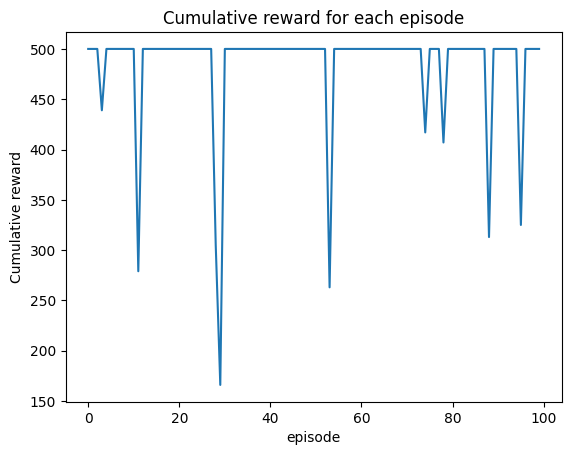

Mean episode result: 484.14


In [17]:
test_model(discount_model)

#**Task 3: Render one episode played by the agent**

The third task involves rendering one episode played the agent on its own, to visually inspect its performance.

In [19]:
env = RecordVideo(gym.make("CartPole-v1"), "./video")
observation = env.reset()
while True:
    env.render()
    #your agent goes here
    action, _ = select_action_from_policy(discount_model, observation)
    observation, reward, done, info = env.step(action)
    if done:
      break;
env.close()
show_video()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [21]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML

def display_video(video):
    fig = plt.figure(figsize=(3,3))  #Display size specification

    mov = []
    for i in range(len(video)):  #Append videos one by one to mov
        img = plt.imshow(video[i], animated=True)
        plt.axis('off')
        mov.append([img])

    #Animation creation
    anime = animation.ArtistAnimation(fig, mov, interval=50, repeat_delay=1000)

    plt.close()
    return anime

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
video = imageio.mimread('/content/video/rl-video-episode-0.mp4', memtest=False)
#video = resize(frame, (256, 256))[..., :3]
HTML(display_video(video).to_html5_video())

# Bibliography
Paszke, A., Gross, S., Massa, F., Lerer, A., Bradbury, J., Chanan, G., ... Chintala, S. (2019). PyTorch: An Imperative Style, High-Performance Deep Learning Library. In H. Wallach, H. Larochelle, A. Beygelzimer, F. d'Alché-Buc, E. Fox, & R. Garnett (Eds.), Advances in Neural Information Processing Systems 32 (pp. 8024-8035). Curran Associates, Inc. Retrieved from http://papers.neurips.cc/paper/9015-pytorch-an-imperative-style-high-performance-deep-learning-library.pdf

Normalization. (n.d.). Google for Developers. https://developers.google.com/machine-learning/data-prep/transform/normalization#:~:text=The%20goal%20of%20normalization%20is,training%20stability%20of%20the%20model

Trencseni, M. (2019, October 21). Solving the CartPole Reinforcement Learning problem with Pytorch. Bytepawn - Marton Trencseni. https://bytepawn.com/solving-the-cartpole-reinforcement-learning-problem-with-pytorch.html
